In [1]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
%matplotlib inline  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint
import eli5
import sklearn

from eli5.sklearn import PermutationImportance
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder, TargetEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import accuracy_score, f1_score, log_loss, classification_report

In [2]:
train = pd.read_csv('data/train_clean.csv', index_col = 0)
X_test = pd.read_csv('data/test_clean.csv', index_col = 0)
submission = pd.read_csv('data/sample_submission.csv')

feature = ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'family_size', 'age', 'work_year', 'use_month', 'income_total']
target = ['credit']

X_train = train[feature]
y_train = train[target]

### Baseline Model

In [3]:
total = len(y_train)
zero = float((y_train == 0).sum() / total)
one = float((y_train == 1).sum() / total)
two = float((y_train == 2).sum() / total)

baseline = [zero, one, two]
baseline_proba = [baseline] * total
baseline_pred = [2] * total

In [4]:
print('Baseline Model')
print('Accuracy : ', accuracy_score(y_train, baseline_pred))
print('Log Loss : ', log_loss(y_train, baseline_proba))
print(classification_report(y_train, baseline_pred))

Baseline Model
Accuracy :  0.641261199954633
Log Loss :  0.8825464036975457
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3222
         1.0       0.00      0.00      0.00      6267
         2.0       0.64      1.00      0.78     16962

    accuracy                           0.64     26451
   macro avg       0.21      0.33      0.26     26451
weighted avg       0.41      0.64      0.50     26451



/Users/prozapple/.pyenv/versions/3.10.3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/prozapple/.pyenv/versions/3.10.3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/prozapple/.pyenv/versions/3.10.3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

## Modeling

### XGB Classifier

In [5]:
xgb_model = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer(strategy = 'median'))),
    ('classifier', XGBClassifier(n_estimators=200, 
                          random_state=42,
                          n_jobs=-1,
                          max_depth=7,
                          learning_rate=0.2))], verbose = 1)

xgb_model.fit(X_train, y_train)

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.2s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=  13.0s


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('ordinalencoder',
                                  OrdinalEncoder(cols=['income_type',
                                                       'edu_type',
                                                       'family_type',
                                                       'house_type',
                                                       'occyp_type'],
                                                 mapping=[{'col': 'income_type',
                                                           'data_type': dtype('O'),
                                                           'mapping': Commercial associate    1
Working                 2
State servant           3
Pensioner               4
Student                 5
NaN                    -2
dtype: int64},
                                                          {'col': 'edu_type',
                                                           'data_type': dtype('O'),
                                                           'mapping': Highe...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.2, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=7, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=200, n_jobs=-1, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=42, reg_alpha=0, ...))],
         verbose=1)

#### Early Stopping

In [ ]:
X_train_transformed = xgb_model.named_steps['preprocessing'].transform(X_train)
X_val_transformed = xgb_model.named_steps['preprocessing'].transform(X_val)

eval_set = [(X_train_transformed, y_train), 
            (X_val_transformed, y_val)]

xgb_model.named_steps['xgb'].fit(X_train_transformed, y_train, 
          eval_set=eval_set,
          eval_metric='mlogloss',
          early_stopping_rounds=50
         ) # 50 rounds 동안 스코어의 개선이 없으면 멈춤

#### Hyperparameter Tunning

In [ ]:
%%time
params = {'classifier__max_depth':[5,6,7,8,9,10,15], 
          'classifier__min_child_weight':[5,7,10,15], 
          'classifier__colsample_bytree':[0.5,0.75],
          'classifier__learning_rate' : uniform(0,0.2)}

randcv = RandomizedSearchCV(xgb_model,
                            param_distributions=params,
                            n_iter = 10,
                            cv=5,
                            scoring = 'neg_log_loss',
                            verbose = 100,
                            random_state = 42)

randcv.fit(X_train, y_train)

#튜닝된 파라미터 출력
print(randcv.best_params_)


In [6]:
xgb_tuned = Pipeline([
    ('preprocessing', make_pipeline(TargetEncoder(), SimpleImputer())),
    ('classifier', XGBClassifier(n_estimators=200, 
                          random_state=42,
                          n_jobs=-1,
                          max_depth=10,
                          colsample_bytree = 0.5,
                          min_child_weight = 5,
                          learning_rate=0.06084844859190755))], verbose = 10)

xgb_tuned.fit(X_train, y_train)


[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.3s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=  19.4s


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('targetencoder',
                                  TargetEncoder(cols=['income_type', 'edu_type',
                                                      'family_type',
                                                      'house_type',
                                                      'occyp_type'])),
                                 ('simpleimputer', SimpleImputer())])),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.5, early_stopping_rounds=No...
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.06084844859190755, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=10, max_leaves=0, min_child_weight=5,
                               missing=nan, monotone_constraints='()',
                               n_estimators=200, n_jobs=-1, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=42, reg_alpha=0, ...))],
         verbose=10)

### Scoring

In [7]:
def model_score(pipe):
    train_acc = pipe.score(X_train, y_train)
    # val_acc = pipe.score(X_val, y_val)

    y_train_proba = pipe.predict_proba(X_train)
    # y_val_proba = pipe.predict_proba(X_val)

    train_logloss = log_loss(y_train, y_train_proba)
    # val_logloss = log_loss(y_val, y_val_proba)

    print('Model Score')
    print('Train Set Accuracy Score : ', train_acc)
    # print('Valid Set Accuracy Score : ', val_acc)

    print('Train Set Log Loss Score : ', train_logloss)
    # print('Valid Set Log Loss Score : ', val_logloss)


In [8]:
model_score(xgb_tuned)
print(classification_report(xgb_tuned.predict(X_train), y_train))

Model Score
Train Set Accuracy Score :  0.7497259082832407
Train Set Log Loss Score :  0.5916905193875351
              precision    recall  f1-score   support

           0       0.19      0.92      0.32       676
           1       0.38      0.87      0.53      2717
           2       0.99      0.73      0.84     23058

    accuracy                           0.75     26451
   macro avg       0.52      0.84      0.56     26451
weighted avg       0.91      0.75      0.80     26451



### RandomForestClassifier

In [ ]:
rfc_model = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer(strategy = 'median'))),
    ('classifier', RandomForestClassifier(n_estimators=200, 
                                   random_state=2,
                                   n_jobs=-1,
                                   max_depth=7))], verbose = 1)

rfc_model.fit(X_train, y_train)

### DecisionTreeClassifier

In [ ]:
dtc_model = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer(strategy = 'median'))),
    ('classifier', DecisionTreeClassifier(
                                   random_state=2,
                                   max_depth=7))], verbose = 1)

dtc_model.fit(X_train, y_train)

### Feature Importance

In [9]:
permuter = PermutationImportance(
    xgb_tuned.named_steps['classifier'],
    scoring = 'neg_log_loss',
    n_iter = 5,
    random_state = 42
)
X_train_transformed = xgb_tuned.named_steps['preprocessing'].transform(X_train)
permuter.fit(X_train_transformed, y_train)

eli5.show_weights(
permuter, 
top=None, # top n 지정 가능, None 일 경우 모든 특성 
feature_names= list(X_train.columns) # list 형식으로 넣어야 합니다
)

Weight,Feature
0.2574 ± 0.0046,use_month
0.1060 ± 0.0010,age
0.0776 ± 0.0008,income_total
0.0753 ± 0.0013,work_year
0.0509 ± 0.0013,occyp_type
0.0340 ± 0.0007,income_type
0.0337 ± 0.0006,family_type
0.0308 ± 0.0007,family_size
0.0263 ± 0.0007,edu_type
0.0211 ± 0.0010,reality


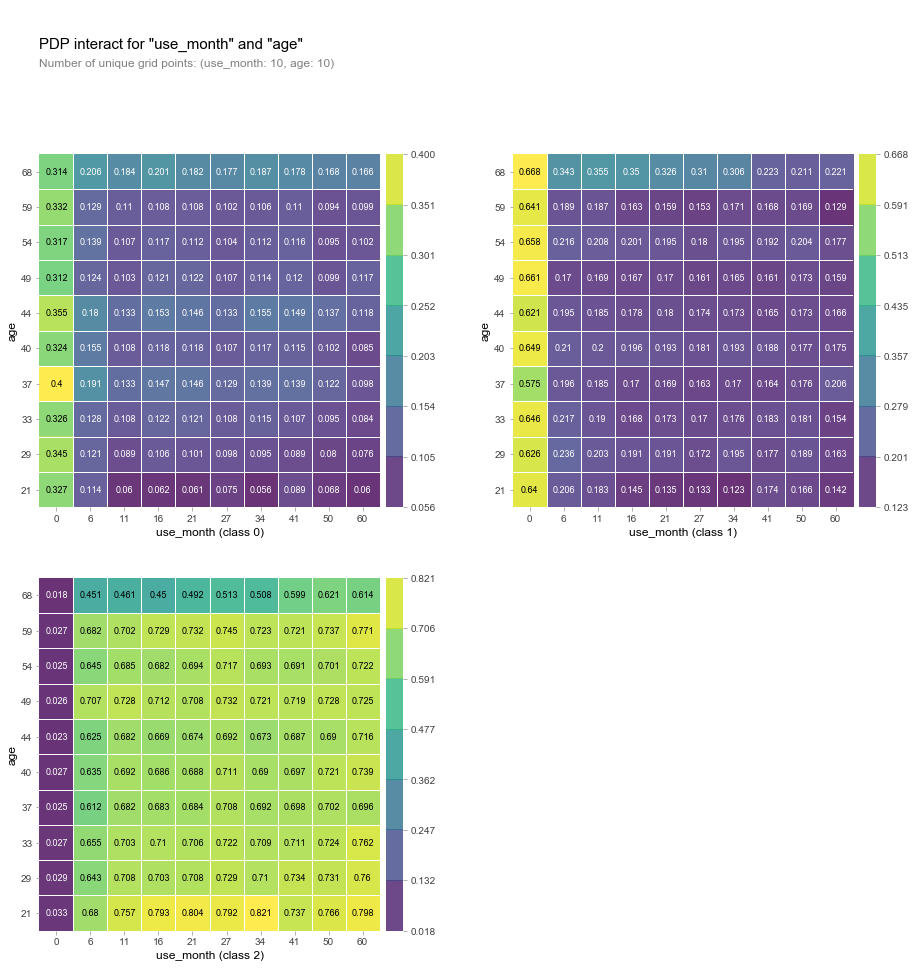

In [10]:
from pdpbox.pdp import pdp_isolate, pdp_plot,pdp_interact, pdp_interact_plot
feature = ['use_month', 'age']
isolated = pdp_interact(
    model=xgb_tuned, 
    dataset=X_train, 
    model_features=X_train.columns, 
    features=feature,
)
pdp_interact_plot(isolated, plot_type='grid', feature_names=feature);

## Submission

In [ ]:
def submit(pipe, num):
    y_test_proba = pipe.predict_proba(X_test)
    submission.iloc[:, 1:] = y_test_proba
    submission.to_csv('data/submission' + str(num) + '.csv', index = False)

In [ ]:
submit(xgb_tuned, 3)